In [3]:
import torch
import torch.nn as nn
import torch.distributions.transforms as transform
import torch.nn.functional as F
import torch.distributions as distrib
from torch.distributions import Uniform, Normal
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Uniform

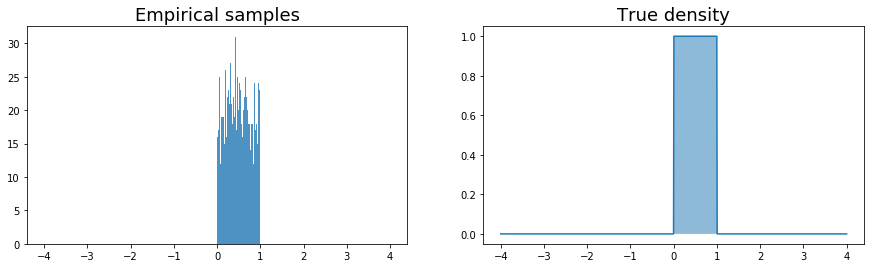

In [4]:
# 
x = np.linspace(-4, 4, 1000)

# Based on a normal
n = distrib.Uniform(0, 1)
# Obtain some samples
samples = n.sample((1000, ))
# Evaluate true density at given points
density = torch.exp(n.log_prob(torch.Tensor(x))).numpy()
# Plot both samples and density
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
ax1.hist(samples, 50, alpha=0.8);
ax1.set_title('Empirical samples', fontsize=18);
ax2.plot(x, density); ax2.fill_between(x, density, 0, alpha=0.5)
ax2.set_title('True density', fontsize=18);


## Data

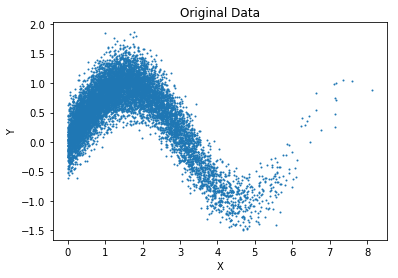

In [5]:
seed = 123
rng = np.random.RandomState(seed=seed)

num_samples = 10000
x = np.abs(2 * rng.randn(num_samples, 1))
y = np.sin(x) + 0.25 * rng.randn(num_samples, 1)
data = np.hstack((x, y))

fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Original Data')
plt.show()

## Univariate Normal Class

```python
self._histogram = histogram
if len(histogram) != 2:
    raise ValueError("Expected length 2 for parameter histogram")
self._hpdf = np.asarray(histogram[0])
self._hbins = np.asarray(histogram[1])
if len(self._hpdf) + 1 != len(self._hbins):
    raise ValueError("Number of elements in histogram content "
                     "and histogram boundaries do not match, "
                     "expected n and n+1.")
self._hbin_widths = self._hbins[1:] - self._hbins[:-1]
self._hpdf = self._hpdf / float(np.sum(self._hpdf * self._hbin_widths))
self._hcdf = np.cumsum(self._hpdf * self._hbin_widths)
self._hpdf = np.hstack([0.0, self._hpdf, 0.0])
self._hcdf = np.hstack([0.0, self._hcdf])
# Set support
kwargs['a'] = self._hbins[0]
kwargs['b'] = self._hbins[-1]
super(rv_histogram, self).__init__(*args, **kwargs)
```

In [6]:
class UnivariateNormalize(Uniform):
    def __init__(self, histogram):
        super(UnivariateNormalize, self).__init__(low=0, high=1)
        
        self.build(histogram)
        
    def build(self, histogram):
        
        # Store Histogram
        pdf, bins = histogram
        
        if len(histogram) != 2:
            raise ValueError("Expected length 2 for parameter histogram.")
        
        # get min-value
        self._hpdf = torch.Tensor(histogram[0])
        print(self._hpdf)
        self._hbins = torch.Tensor(histogram[1])
        
        if len(self._hpdf) + 1 != len(self._hbins):
            raise ValueError("Number of elements in histogram content "
                             "and histogram boundaries do not mathc, "
                             "expected n and n+1.")
        
        self._hbins_widths = self._hbins[1:] - self._hbins[:-1]
        self._hpdf = self._hpdf / (self._hpdf * self._hbins_widths).sum()
        print(self._hpdf)
        self._hcdf = (self._hpdf * self._hbins_widths).cumsum(dim=0)
        
        self._hpdf = torch.cat((torch.Tensor(1), self._hpdf, torch.Tensor(1)), dim=0)
        self._hcdf = torch.cat((torch.Tensor(1), self._hcdf), dim=0)

In [7]:
hist, bin_edges = np.histogram(x, bins=10)

print(hist, bin_edges)
histogram_test_instance = UnivariateNormalize((hist, bin_edges))

[3121 2707 1929 1221  616  277   95   22    9    3] [1.51053221e-04 8.13755331e-01 1.62735961e+00 2.44096389e+00
 3.25456816e+00 4.06817244e+00 4.88177672e+00 5.69538100e+00
 6.50898527e+00 7.32258955e+00 8.13619383e+00]
tensor([3.1210e+03, 2.7070e+03, 1.9290e+03, 1.2210e+03, 6.1600e+02, 2.7700e+02,
        9.5000e+01, 2.2000e+01, 9.0000e+00, 3.0000e+00])
tensor([3.8360e-01, 3.3272e-01, 2.3709e-01, 1.5007e-01, 7.5712e-02, 3.4046e-02,
        1.1676e-02, 2.7040e-03, 1.1062e-03, 3.6873e-04])


### Statistics

```python

def _cdf(self, x):
    """
    CDF calculated from the histogram
    """
    return np.interp(x, self._hbins, self._hcdf)

def _ppf(self, x):
    """
    Percentile function calculated from the histogram
    """
    return np.interp(x, self._hcdf, self._hbins)
```

In [8]:
class UnivariateNormalize(Uniform):
    def __init__(self, histogram):
        super(UnivariateNormalize, self).__init__(low=0, high=1)
        
        self.build(histogram)
        
    def build(self, histogram):
        
        # Store Histogram
        pdf, bins = histogram
        
        if len(histogram) != 2:
            raise ValueError("Expected length 2 for parameter histogram.")
        
        # get min-value
        self._hpdf = torch.Tensor(histogram[0])
        self._hbins = torch.Tensor(histogram[1])
        
        if len(self._hpdf) + 1 != len(self._hbins):
            raise ValueError("Number of elements in histogram content "
                             "and histogram boundaries do not mathc, "
                             "expected n and n+1.")
        
        self._hbins_widths = self._hbins[1:] - self._hbins[:-1]
        self._hpdf = self._hpdf / (self._hpdf * self._hbins_widths).sum()
        self._hcdf = (self._hpdf * self._hbins_widths).cumsum(dim=0)
        
        self._hpdf = torch.cat((torch.Tensor(1), self._hpdf, torch.Tensor(1)), dim=0)
        self._hcdf = torch.cat((torch.Tensor(1), self._hcdf), dim=0)
        
    def cdf(self, value):
        return torch.from_numpy(np.interp(value, self._hbins.numpy(), self._hcdf.numpy()))
    
    def icdf(self, value):
        return torch.from_numpy(np.interp(value, self._hcdf.numpy(), self._hbins.numpy()))

In [54]:
x = np.sort(np.abs(2 * rng.randn(num_samples)))
y = np.sort(np.sin(x) + 0.25 * rng.randn(num_samples))

hist, bin_edges = np.histogram(y, bins=100)

print(hist.shape, bin_edges.shape)

u = UnivariateNormalize((hist, bin_edges))

(100,) (101,)


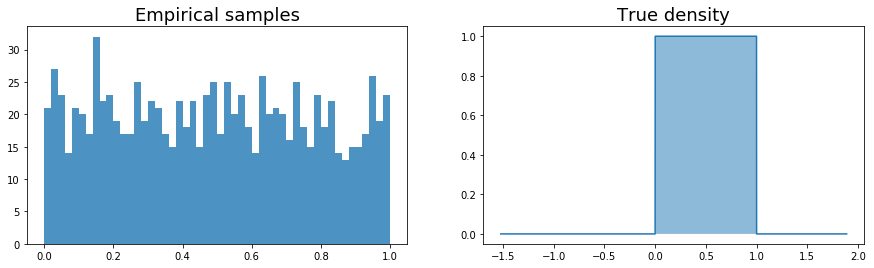

In [27]:
# Obtain some samples
samples = u.sample((1000, ))

# Evaluate true density at given points
density = torch.exp(u.log_prob(torch.Tensor(y))).numpy()

# Plot both samples and density
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15, 4))

ax1.hist(samples, 50, alpha=0.8);
ax1.set_title('Empirical samples', fontsize=18);

ax2.plot(y, density,); 
ax2.fill_between(y, density, 0, alpha=0.5)
ax2.set_title('True density', fontsize=18);

plt.show()

In [64]:
x_plot = np.linspace(y.min(), y.max(), 1000)
x_pdf = u.sample((1000, 1)).numpy()
x_cdf = u.cdf(x_plot).numpy()
x_icdf = u.icdf(x_plot).numpy()

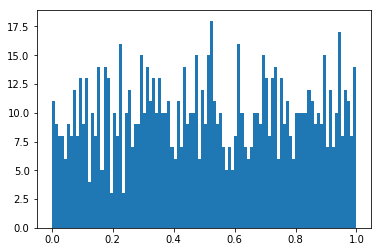

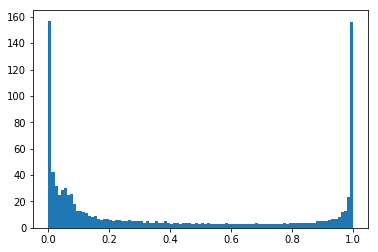

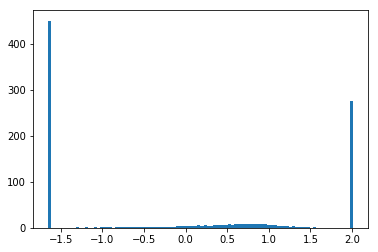

In [66]:
fig, ax = plt.subplots()

ax.hist(x_pdf, bins=100)

plt.show()

fig, ax = plt.subplots()

ax.hist(x_cdf, bins=100)

plt.show()

fig, ax = plt.subplots()

ax.hist(x_icdf, bins=100)

plt.show()

### Normal Distribution

In [56]:
# Initialize Normal Distribution
n = distrib.Normal(0, 1)

# Transform
x_trans = n.icdf(torch.Tensor(x_icdf))

/Users/eman/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/eman/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


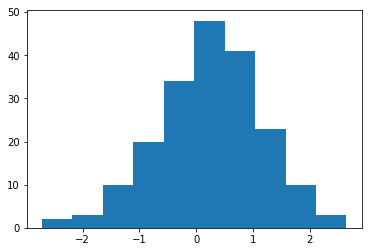

In [58]:
fig, ax = plt.subplots()

ax.hist(x_trans.numpy())

plt.show()

In [ ]:
exp_t = transform.Nor()
q1 = distrib.TransformedDistribution(q0, exp_t)
samples_q0 = q0.sample((int(1e4),))
samples_q1 = q1.sample((int(1e4),))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.hist(samples_q0, 50, alpha=0.8);
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18);
ax2.hist(samples_q1, 50, alpha=0.8, color='g');
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);

In [ ]:
n = Normal.d

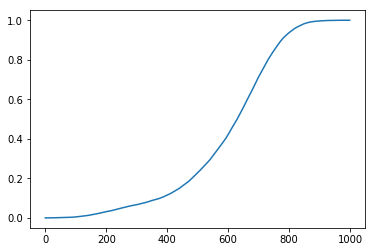

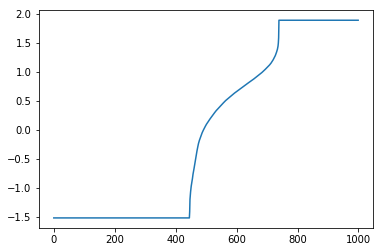

In [30]:
fig, ax = plt.subplots()

ax.plot(x_cdf)

plt.show()

fig, ax = plt.subplots()

ax.plot(x_icdf)

plt.show()

In [ ]:
x_plot = np.linspace(x.min(), x.max(), 1000)
x_cdf = u.cdf(x_plot).numpy()
x_icdf = u.icdf(x_plot).numpy()

In [166]:
x_sample = u.sample((1000, ))

ValueError: Input passed into argument "'x'"is not 1-dimensional.

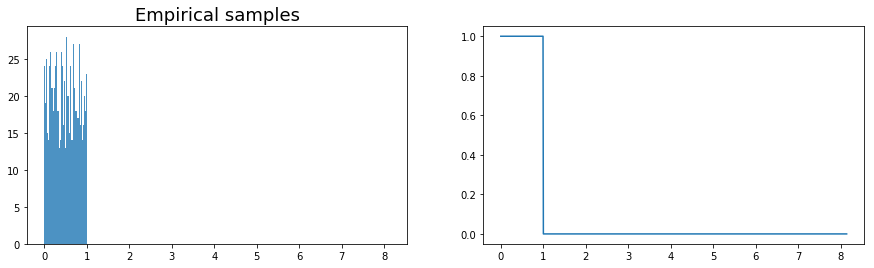

In [167]:
# Obtain some samples
samples = u.sample((1000, ))

# Evaluate true density at given points
density = torch.exp(u.log_prob(torch.Tensor(x_plot))).numpy()

# Plot both samples and density
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
ax1.hist(samples, 50, alpha=0.8);
ax1.set_title('Empirical samples', fontsize=18);
ax2.plot(x_plot, density); ax2.fill_between(x, density, 0, alpha=0.5)
ax2.set_title('True density', fontsize=18);